In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import everything for vision tasks from FastAI v2
from fastai.vision.all import *

from fastai.callback.all import *

from fastai.torch_core import *


In [ ]:
# !pip install fastai --upgrade
# !pip install -Uqq fastai


In [ ]:
from PIL import Image


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.CAMVID)
path.ls()


(#4) [Path('/root/.fastai/data/camvid/valid.txt'),Path('/root/.fastai/data/camvid/labels'),Path('/root/.fastai/data/camvid/codes.txt'),Path('/root/.fastai/data/camvid/images')]

## Setting up the path

In [ ]:
!cp -r {path} '/content/drive/My Drive/CamVid2'
path = Path('/content/drive/My Drive/CamVid2')
path.ls()


^C


(#1) [Path('/content/drive/My Drive/CamVid2/camvid')]

In [ ]:
!ls '/content/drive/My Drive/CamVid2'


camvid


In [ ]:
path = Path('/content/drive/My Drive/CamVid2/camvid')

In [ ]:
path2 = Path('/content/drive/My Drive/CamVid2/camvid')

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'
codes = np.loadtxt(path/'codes.txt', dtype=str)


## Show some sample image paths and label paths



In [ ]:

fnames = get_image_files(path_img)
fnames[:3]


(#3) [Path('/content/drive/My Drive/CamVid2/camvid/images/Seq05VD_f02520.png'),Path('/content/drive/My Drive/CamVid2/camvid/images/Seq05VD_f03060.png'),Path('/content/drive/My Drive/CamVid2/camvid/images/Seq05VD_f02160.png')]

In [ ]:
# for label
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/content/drive/My Drive/CamVid2/camvid/labels/0001TP_009690_P.png'),Path('/content/drive/My Drive/CamVid2/camvid/labels/0016E5_08073_P.png'),Path('/content/drive/My Drive/CamVid2/camvid/labels/0016E5_04470_P.png')]

<Axes: >

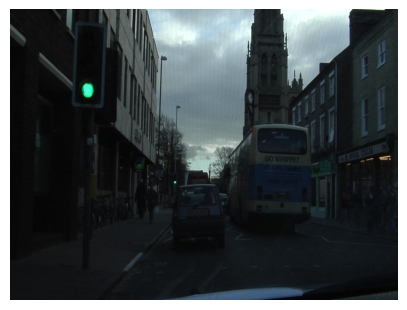

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

# Show a sample image
img_f = fnames[219]
img = PILImage.create(img_f)  # Using PILImage.create to load the image
img.show(figsize=(5, 5))  # This uses the integrated show method with matplotlib's figsize


In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'


In [ ]:
get_y_fn(img_f)


Path('/content/drive/My Drive/CamVid2/camvid/labels/0001TP_006750_P.png')

## Analysis on the data

<Axes: >

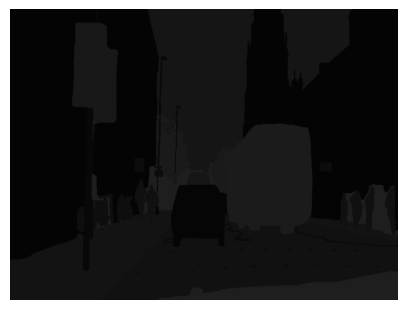

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

img_f = fnames[219]
label_path = get_y_fn(img_f) # fn gettfn -> for lable path

# Open the label image
label_img = PILImage.create(label_path)
label_img.show(figsize=(5, 5), cmap='tab20')  # Using a color map suitable for viewing label images


### Loading segmentation mask wh colormap


<Axes: >

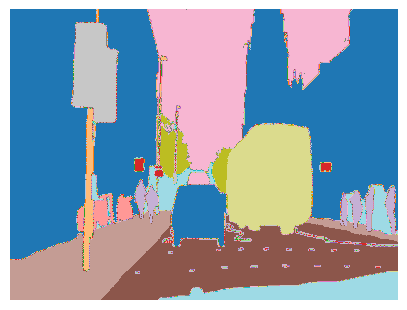

In [ ]:
img_f = fnames[219]
mask_path = get_y_fn(img_f)

mask = PILMask.create(mask_path)
mask.show(figsize=(5, 5), alpha=1, cmap='tab20')  # Using a colormap that helps distinguish mask labels


In [ ]:
from fastai.vision.all import *

img_f = fnames[219]
mask_path = get_y_fn(img_f)
mask = PILMask.create(mask_path)

# Accessing the size of the seg mask
src_size = np.array(mask.size[::-1])  # gives (width, height) and we need (height, width)

mask_tensor = np.array(mask)  # PILMask to a numpy array

# Display the size and data
src_size, mask_tensor


(array([720, 960]),
 array([[ 4,  4,  4, ...,  4,  4,  4],
        [ 4,  4,  4, ...,  4,  4,  4],
        [ 4,  4,  4, ...,  4,  4,  4],
        ...,
        [19, 19, 19, ..., 30, 30, 30],
        [19, 19, 19, ..., 30, 30, 30],
        [19, 19, 19, ..., 30, 30, 30]], dtype=uint8))

In [ ]:

codes = np.loadtxt(path/'codes.txt', dtype=str)
codes


array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Checking with our memory constraints:


In [ ]:
defaults.device = torch.device('cuda') #Using Gpu


In [ ]:
torch.cuda.is_available()


True

## Data building


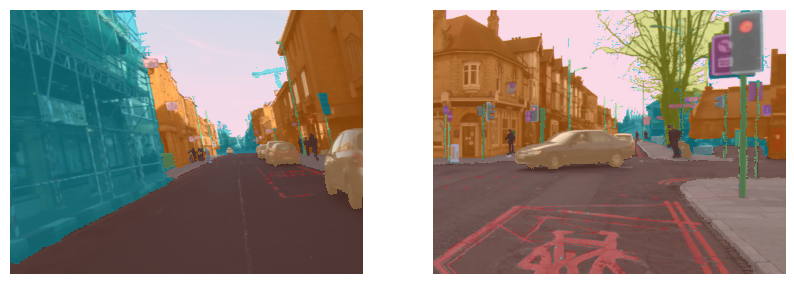

In [ ]:
from fastai.vision.all import *
from pathlib import Path

# Paths setup
path = Path('/content/drive/My Drive/CamVid2/camvid')
path_img = path/'images'
path_lbl = path/'labels'
valid_file = path/'valid.txt'
codes = np.loadtxt(path/'codes.txt', dtype=str)

# Function to get corresponding label file paths
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

# Define the DataBlock for segmentation
segmentation = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    splitter=FileSplitter(valid_file),
    get_items=get_image_files,
    get_y=get_y_fn,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=(360, 480)), Normalize.from_stats(*imagenet_stats)]
)

# Create DataLoaders
dls = segmentation.dataloaders(path_img, bs=8)

# Show a random batch of data
dls.show_batch(max_n=2, figsize=(10,7))


In FastAI v2, you can simply use the subset argument to specify whether you want to show a batch from the training set or the validation set. Here's how you can correctly display a batch of validation data in FastAI v2:

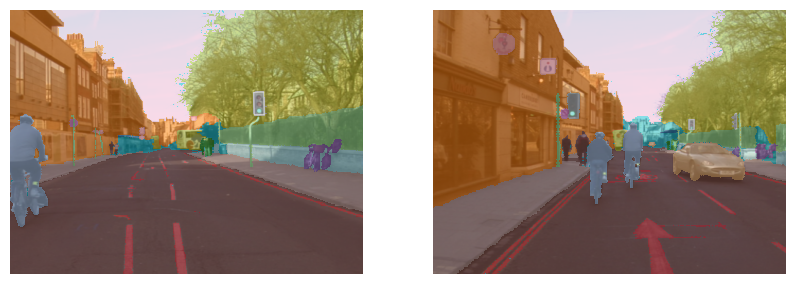

In [ ]:

# Showing a random batch of validation data
dls.valid.show_batch(max_n=2, figsize=(10,7))


## Model building


 U-Net model 1 of most common architectures that are used for segmentation tasks. A U-Net architecture looks something like this :

Mor link https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/.

Also, we're going to be using a pre-trained model called ResNet34 inside the U-Net architecture.

In [ ]:
'''
We first have to create a custom accuracy function for our model because
there are a few images with 'void' labels assigned to them, which we need
to ignore while calculating accuracy.
'''

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
# Hyperparameters
metrics = acc_camvid
wd = 1e-2  # weight decay

In [ ]:
# create unet model
learn = unet_learner(dls, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.8MB/s]


SuggestedLRs(valley=5.248074739938602e-05)

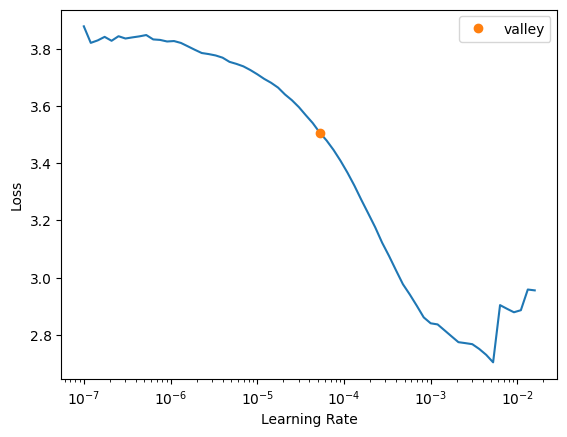

In [ ]:
# Create a U-Net learner
learn = unet_learner(dls, resnet34, metrics=acc_camvid, wd=1e-2)

# Find an optimal learning rate
learn.lr_find()



The red dot on the graph recommends a lr that might be good for our training. The exact point that it corresponds to on the x-axis is also given to us at the top of the plot by the name 'Min numerical gradient'. We can simply use this number for our lr and we're good to g

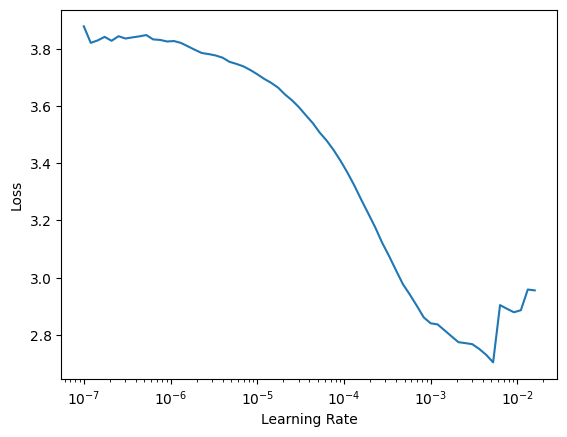

In [ ]:
# Plot the learning rate finder results
learn.recorder.plot_lr_find()


In [ ]:
# Manually set the learning rate based on the plot
min_grad_lr = 1e-3  # Adjusting based on plot

# Training the model
learn.fit_one_cycle(10, slice(min_grad_lr), pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,time
0,1.381832,0.955170,0.767699,01:47
1,0.898700,0.697069,0.836854,01:30
2,0.732516,0.668767,0.829842,01:33
3,0.613080,0.527041,0.848606,01:30
4,0.567843,0.487969,0.866235,01:30
5,0.521123,0.445582,0.877250,01:31
6,0.509122,0.486127,0.869012,01:30


epoch,train_loss,valid_loss,acc_camvid,time
0,1.381832,0.955170,0.767699,01:47
1,0.898700,0.697069,0.836854,01:30
2,0.732516,0.668767,0.829842,01:33
3,0.613080,0.527041,0.848606,01:30
4,0.567843,0.487969,0.866235,01:30
5,0.521123,0.445582,0.877250,01:31
6,0.509122,0.486127,0.869012,01:30
7,0.464461,0.412919,0.876997,01:30
8,0.460956,0.467771,0.875861,01:31


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f7183a7d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79f7183a7d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

In [ ]:
# Save the trained model
learn.save('stage-1')

# # Load the model and display results
# learn.load('stage-1')
# learn.show_results(max_n=3, figsize=(8,9))

In [ ]:
# Load the model and display results
learn.load('stage-1')
learn.show_results(rows=3, figsize=(8,9))

In [ ]:

# Plot training and validation losses
learn.recorder.plot_losses()

In [ ]:
## For 10 -4

In [ ]:
# Manually set the learning rate based on the plot
min_grad_lr = 1e-4  # Adjusting based on plot correct

# Training the model
learn.fit_one_cycle(10, slice(min_grad_lr), pct_start=0.9)


In [ ]:
break

# Dump below

In [ ]:
# Extract the suggested learning rate
min_grad_lr = learn.recorder.min_grad_lr
print(f"Suggested Learning Rate: {min_grad_lr}")

AttributeError: 'DynamicUnet' object has no attribute 'min_grad_lr'

In [ ]:
lr1 = min_grad_lr1


In [ ]:
# learn.fit_one_cycle(10, slice(lr1), pct_start=0.9)   # pc_start denotes the percentage of total number of epochs when learning rate rises during one cycle.


In [ ]:
# # Training the model
# learn.fit_one_cycle(10, slice(min_grad_lr), pct_start=0.9)

# # Save the trained model
# learn.save('stage-1')

# # Load the model and display results
# learn.load('stage-1')
# learn.show_results(max_n=3, figsize=(8,9))

In [ ]:

# min_grad_lr1 = learn.recorder.min_grad_lr
# min_grad_lr1

In [ ]:
# lr1 = min_grad_lr1


## **Training for 10 epochs:**



In [ ]:
learn.fit_one_cycle(10, slice(lr1), pct_start=0.9)   # pc_start denotes the percentage of total number of epochs when learning rate rises during one cycle.


We are already at a pretty good accuracy of about 89% with seemingly good training and validation losses as well. We can also plot the losses to see their learning curve over batches processed. Ideally, we'd like to have both these losses get as low as possible and as close to each other as possible.



## Plotting Losses

In [ ]:
learn.recorder.plot_losses()


In [ ]:
learn.save('stage-1')


In [ ]:
learn.load('stage-1');


In [ ]:

# show some sample results
learn.show_results(rows=3, figsize=(8,9))


In [ ]:
learn.unfreeze()


In [ ]:

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr2 = learn.recorder.min_grad_lr
min_grad_lr2

In [ ]:
lr2 = min_grad_lr2


In [ ]:
learn.fit_one_cycle(12, slice(lr2), pct_start=0.8)


So after unfreezing and training again with a new appropriate lr, we have increased the accuracy from 89% last time to 91% this time.

In [ ]:

# show some sample results
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
learn.save('stage-2')


In [ ]:
learn.destroy()   # optional

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")


In [ ]:

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)


In [ ]:
learn.load('stage-2');  # loading the previously saved model


In [ ]:

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:

min_grad_lr3 = learn.recorder.min_grad_lr
min_grad_lr3

In [ ]:
lr3 = min_grad_lr3


In [ ]:
learn.fit_one_cycle(10, slice(lr3), pct_start=0.8)


Clearly, we are already at a higher accuracy of 91.4% this time from 91.01% last time.



In [ ]:
learn.save('stage-1-big')  #save the model


Again, unfreeze the model and train it for one last time.



In [ ]:

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:

min_grad_lr4 = learn.recorder.min_grad_lr
min_grad_lr4


In [ ]:
lr4 = min_grad_lr4


In [ ]:
learn.fit_one_cycle(10, slice(lr4, lr3/10))


In [ ]:
learn.recorder.plot_losses()  # plotting the train and valid losses


Our losses are pretty low and close which is permissible at this point. We can thus be assured of a good model by now and save it for future use.



In [ ]:
learn.save('stage-2-big')


In [ ]:
# show some results
learn.show_results(rows=3, figsize=(10, 10))